<a href="https://colab.research.google.com/github/cesaenv/buscaminas/blob/main/practica8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 8. Ejercicio adicional 1: Sudoku. Parte II.

Este notebook es el menos guiado de la asignatura. El objetivo es combinar todo lo que hemos visto a lo largo del curso para leer un Sudoku y resolverlo. Para ello tendrás que utilizar lo visto en la práctica anterior, y además [un algoritmo para resolver Sudokus](http://norvig.com/sudoku.html). A la hora de leer los dígitos del Sudoku puedes utilizar cualquiera de estas aproximaciones:
- Utilizar propiedades de contornos como vimos en la práctica anterior.
- [Utilizar la librería pytesseract](https://www.pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/).
- [Entrenar un modelo basado en el dataset MNIST](https://www.pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/).

##Resolución de Sudoku

Gracias a la página web proporcionada, logramos una función que pasado una string del estilo:

 `'4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'`

 logra resolver el sudoku y mostrarlo por pantalla. Primero definiré las funciones para resolver el sudoku:




In [5]:
def solve_sudoku(grid):
    """Resuelve un Sudoku dado en formato de string."""
    digits = '123456789'
    rows = 'ABCDEFGHI'
    cols = digits

    def cross(A, B):
        """Producto cruzado de elementos en A y elementos en B."""
        return [a+b for a in A for b in B]

    boxes = cross(rows, cols)
    unitlist = ([cross(rows, c) for c in cols] +
                [cross(r, cols) for r in rows] +
                [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
    units = dict((s, [u for u in unitlist if s in u]) for s in boxes)
    peers = dict((s, set(sum(units[s],[]))-set([s])) for s in boxes)

    def grid_values(grid):
        """Convierte una cadena de dígitos en un dict de celdas {celda: valor}."""
        chars = [c for c in grid if c in digits or c in '0.']
        assert len(chars) == 81
        return dict(zip(boxes, chars))

    def parse_grid(grid):
        """Convertir la cuadrícula en un dict, Eliminar valores nulos."""
        values = dict((s, digits) for s in boxes)
        for s,d in grid_values(grid).items():
            if d in digits and not assign(values, s, d):
                return False  # Imposible resolver el sudoku
        return values

    def assign(values, s, d):
        """Asigna un valor d a una celda s, después, eliminar el valor d de todas las celdas peers."""
        other_values = values[s].replace(d, '')
        if all(eliminate(values, s, d2) for d2 in other_values):
            return values
        else:
            return False

    def eliminate(values, s, d):
        """Eliminar el valor d de la celda s; propagar cuando queda una sola posibilidad en una celda."""
        if d not in values[s]:
            return values  # Ya se eliminó d de la celda s
        values[s] = values[s].replace(d, '')
        if len(values[s]) == 0:
            return False  # Contradicción: se eliminó el último valor
        elif len(values[s]) == 1:
            d2 = values[s]
            if not all(eliminate(values, s2, d2) for s2 in peers[s]):
                return False
        # (1) Si hay un cuadrado en la unidad s que puede tener valor d, entonces el valor d debe estar en una de esas celdas.
        for u in units[s]:
            dplaces = [s for s in u if d in values[s]]
            if len(dplaces) == 0:
                return False  # Contradicción: no hay lugar para este valor
            elif len(dplaces) == 1:
                # (2) Si solo hay un lugar para el valor d en la unidad, coloque allí el valor d.
                if not assign(values, dplaces[0], d):
                    return False
        return values

    def search(values):
        """Usar búsqueda y propagación para resolver el sudoku, devolviendo values, o False si no se puede resolver."""
        if values is False:
            return False  # Fallo previo
        if all(len(values[s]) == 1 for s in boxes):
            return values  # Sudoku resuelto
        # Elija la celda no resuelta s con el valor mínimo posible
        n,s = min((len(values[s]), s) for s in boxes if len(values[s]) > 1)
        # Intenta resolver cada una de las recursiones resultantes
        for value in values[s]:
            new_sudoku = values.copy()
            new_sudoku[s] = value
            attempt = search(new_sudoku)
            if attempt:
                return attempt

    return search(parse_grid(grid))


Luego defino una función que muestre el sudoku solucionado, las respuestas tendrán la forma:

 `'{'A1': '4', 'A2': '1', 'A3': '1', 'A4': '1', 'A5': '2', 'A6': '2', 'A7': '8', 'A8':...'`







In [6]:
def display_sudoku_solution(solution):
    """Muestra la solución del sudoku en un formato legible."""
    digits = '123456789'
    rows = 'ABCDEFGHI'
    cols = digits

    def cross(A, B):
        """Producto cruzado de elementos en A y elementos en B."""
        return [a+b for a in A for b in B]

    boxes = cross(rows, cols)

    # Mostrar la solución del sudoku
    width = 1 + max(len(solution[s]) for s in boxes)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(solution[r+c].center(width)+('|' if c in '36' else '') for c in cols))
        if r in 'CF': print(line)

Propongo un ejemplo de uso:

In [7]:
# Ejemplo de uso:
sudoku_string = '4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
sudoku_resuelto = solve_sudoku(sudoku_string)
if sudoku_resuelto:
  display_sudoku_solution(sudoku_resuelto)
else:
    print("No se puede resolver el Sudoku.")

4 1 1 |1 2 2 |8 1 5 
2 3 1 |1 2 2 |1 1 1 
2 1 1 |7 2 2 |1 1 1 
------+------+------
3 2 1 |3 3 4 |1 6 1 
3 1 1 |3 8 2 |4 1 1 
3 4 5 |3 1 2 |2 2 2 
------+------+------
2 8 2 |6 4 3 |1 7 1 
5 6 3 |2 4 1 |6 4 4 
1 6 4 |5 5 5 |2 2 2 


##Generar Tablero

Para el segundo paso, es generar el tablero dado por una imagen. Esto es lo que se realizó en la práctica anterior (Práctica 7, ejercicio adicional 2). Por lo tanto, lo primero que hacer será importar la función conseguida en esa misma práctica:


In [8]:
#importamos las librerías necesarias
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
%matplotlib inline

In [9]:
#función para mostrar la imágen obtenida
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

In [10]:
#función para ordenar los contornos
def sort_contours(cnts):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:(b[1][1],b[1][0]), reverse=False))
    return cnts

In [48]:
#función ue dada una imagen, compruebe si la imagen es completamente blanca (es decir todos sus píxeles tienen valor igual a 255),
#si dicha lista es vacía devuelve el carácter '.' en caso contrario devuelve el carácter '?'
def vacia(imagen):
  for row in imagen:
    for pixel in row:
      if pixel != 0:
        return '?'
  return '.'

In [14]:
#función para contornear la imagen
def contornoImagen(contornos,thresh):
  resultado = ""
  for (i, c) in enumerate(contornos):
    area = cv2.contourArea(c)
    (x, y, w, h) = cv2.boundingRect(c)
    if(area>1000 and area<3000):
      roi = thresh[y+2:y+h-2, x+2:x+w-2]
      casilla = vacia(roi)
      if(casilla=='?'):
        casilla = resultadoCasilla(roi)
      resultado = resultado + casilla
  return resultado

In [15]:
def generaTablero(imagenPath):
  sudoku = cv2.imread(imagenPath)
  mostrarImagen(sudoku)
  clone = sudoku.copy()
  gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)[1]
  contornos, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contornos = sort_contours(contornos)
  print(contornoImagen(contornos,thresh))

##Obtener el dígito de la casilla

En el apartado anterior, hemos necesitado la función resultadoCasilla(imagen), en este paso definiremos la función, que devolverá un char con el resultado del dígito de la casilla que se encuentra en la imagen pasada por parámetros. Para lograrlo, utilizaré las características de los contornos.

In [16]:
#Defino la siguiente función gracias a una parte de la práctica 8
def verPropiedadesContornos(cnts,image):
  for (i, c) in enumerate(cnts):
    # Calculamos diversas propiedades
    area = cv2.contourArea(c)
    (x, y, w, h) = cv2.boundingRect(c)
    aspectRatio = w / float(h)
    extent = area / float(w * h)
    hull = cv2.convexHull(c)
    hullArea = cv2.contourArea(hull)
    solidity = area / float(hullArea)

    # Visualizamos cada contorno y el convex hull asociado al mismo
    cv2.drawContours(clone, [c], -1, (240, 0, 159), 3)
    print("Contorno #{} -- solidity={:.2f} -- area={:.2f} -- aspectRatio={:.2f} -- extent={:.2f} -- hullArea={:.2f}".
          format(i + 1, solidity,area,aspectRatio,extent,hullArea))
    clone = image.copy()
    cv2.drawContours(clone, [c], -1, (0, 255, 0), 3)
    mostrarImagen(clone)

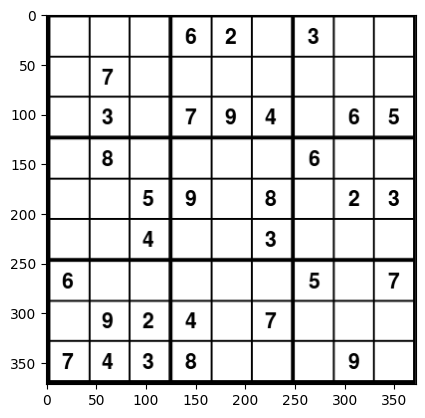

In [46]:
#pongo un ejemplo de sudoku ya resuelto para obtener todos los posibles numeros (del 1 al 9)
image = cv2.imread("imágenes/sudoku1.png")
clone = image.copy()
gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)[1]
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sort_contours(contours)
mostrarImagen(gray)

In [55]:
def contornoImagen(contornos,thresh):
  for (i, c) in enumerate(contornos):
    area = cv2.contourArea(c)
    (x, y, w, h) = cv2.boundingRect(c)
    if(area>1000 and area<3000):
      roi = thresh[y+2:y+h-2, x+2:x+w-2]
      if(vacia(roi)=="?"):
        funcion1(roi)

Contorno #1 -- solidity=0.70 -- area=72.00 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=103.50


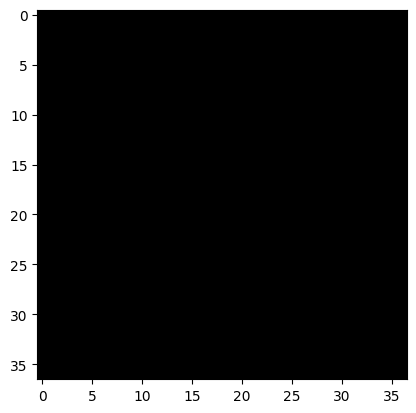

Contorno #2 -- solidity=1.00 -- area=33.00 -- aspectRatio=0.88 -- extent=0.59 -- hullArea=33.00


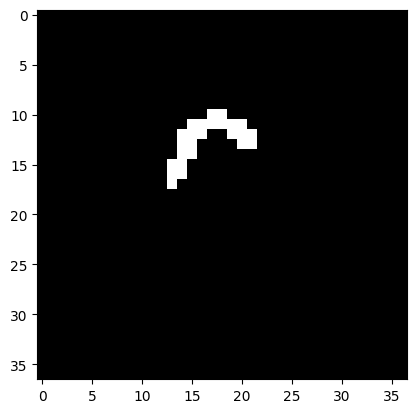

Contorno #1 -- solidity=0.35 -- area=39.50 -- aspectRatio=0.56 -- extent=0.27 -- hullArea=112.50


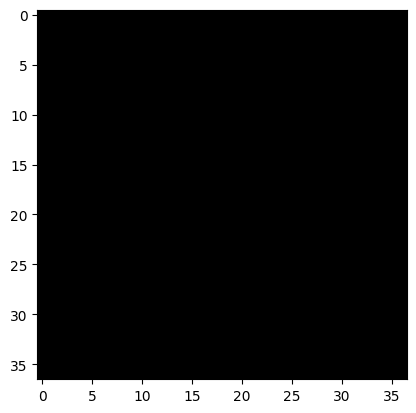

Contorno #1 -- solidity=0.30 -- area=33.00 -- aspectRatio=0.56 -- extent=0.23 -- hullArea=108.50


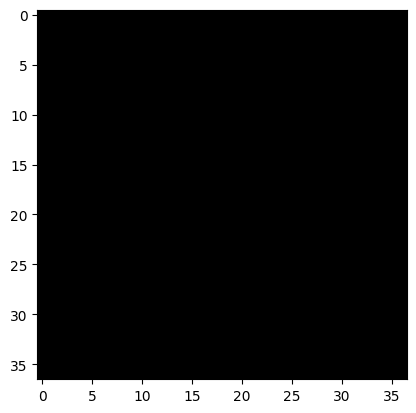

Contorno #1 -- solidity=0.29 -- area=25.00 -- aspectRatio=0.62 -- extent=0.16 -- hullArea=85.50


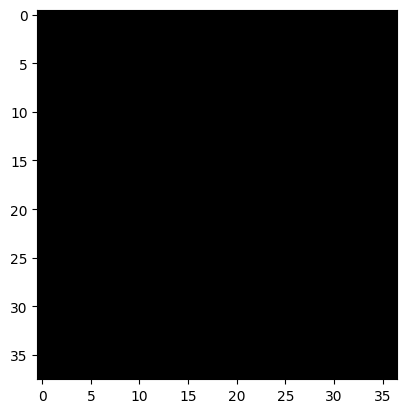

Contorno #1 -- solidity=0.30 -- area=33.00 -- aspectRatio=0.56 -- extent=0.23 -- hullArea=108.50


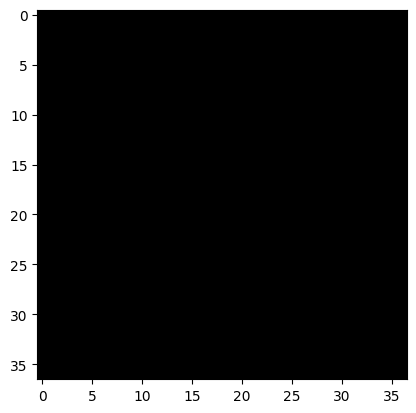

Contorno #1 -- solidity=0.29 -- area=25.00 -- aspectRatio=0.62 -- extent=0.16 -- hullArea=85.50


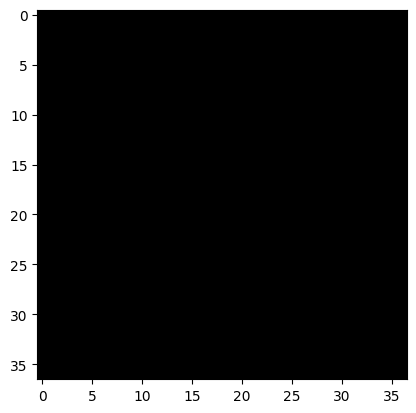

Contorno #1 -- solidity=0.68 -- area=72.50 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=106.00


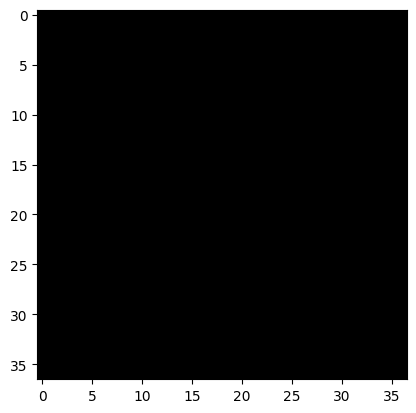

Contorno #2 -- solidity=1.00 -- area=34.00 -- aspectRatio=0.88 -- extent=0.61 -- hullArea=34.00


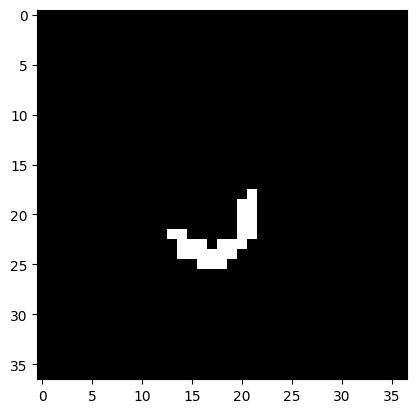

Contorno #1 -- solidity=0.69 -- area=61.00 -- aspectRatio=0.62 -- extent=0.38 -- hullArea=88.00


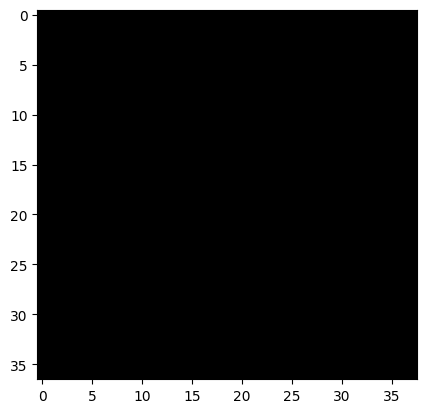

Contorno #2 -- solidity=0.94 -- area=29.00 -- aspectRatio=0.78 -- extent=0.46 -- hullArea=31.00


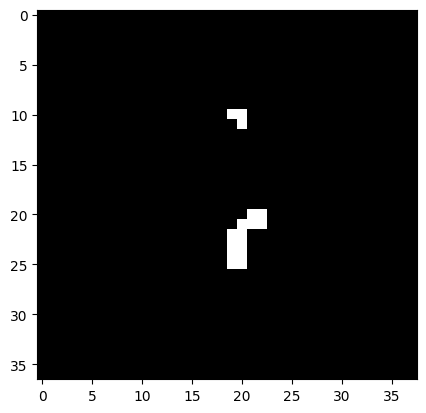

Contorno #1 -- solidity=0.70 -- area=72.00 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=103.50


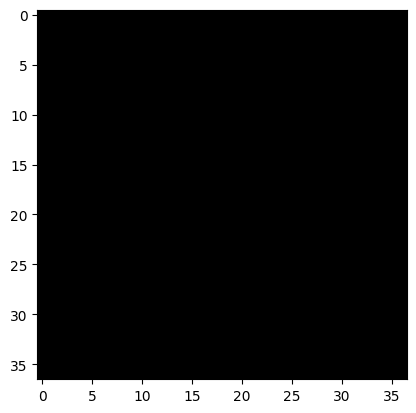

Contorno #2 -- solidity=1.00 -- area=33.00 -- aspectRatio=0.88 -- extent=0.59 -- hullArea=33.00


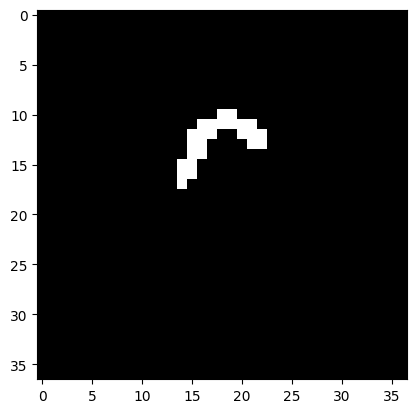

Contorno #1 -- solidity=0.33 -- area=36.50 -- aspectRatio=0.56 -- extent=0.25 -- hullArea=109.00


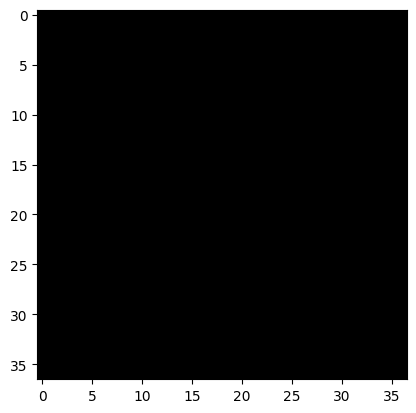

Contorno #1 -- solidity=0.88 -- area=98.50 -- aspectRatio=0.62 -- extent=0.62 -- hullArea=112.50


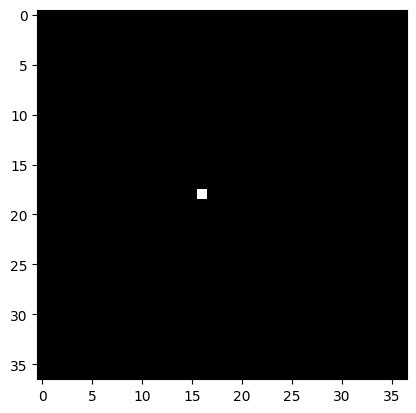

Contorno #2 -- solidity=1.00 -- area=27.00 -- aspectRatio=1.00 -- extent=0.55 -- hullArea=27.00


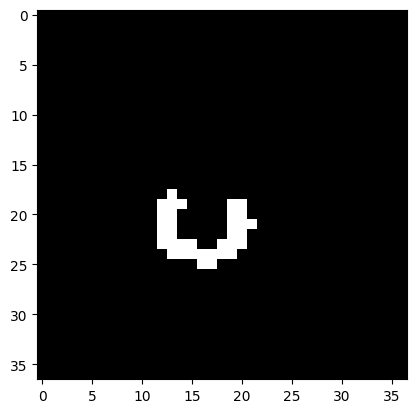

Contorno #3 -- solidity=0.98 -- area=28.50 -- aspectRatio=1.00 -- extent=0.58 -- hullArea=29.00


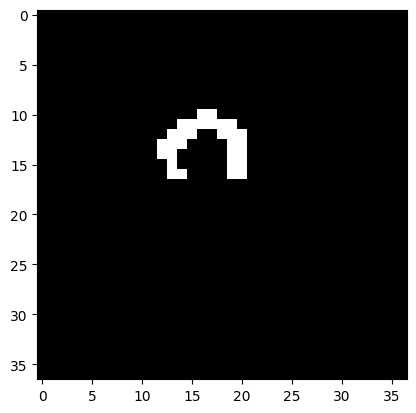

Contorno #1 -- solidity=0.70 -- area=72.00 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=103.50


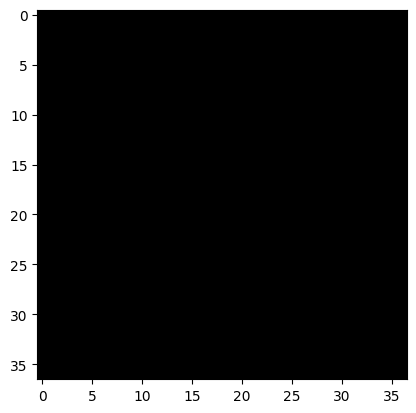

Contorno #2 -- solidity=1.00 -- area=33.00 -- aspectRatio=0.88 -- extent=0.59 -- hullArea=33.00


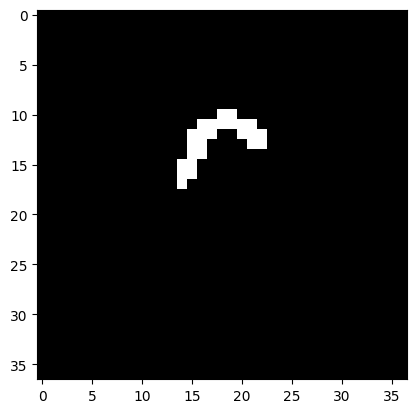

Contorno #1 -- solidity=0.33 -- area=36.50 -- aspectRatio=0.56 -- extent=0.25 -- hullArea=109.00


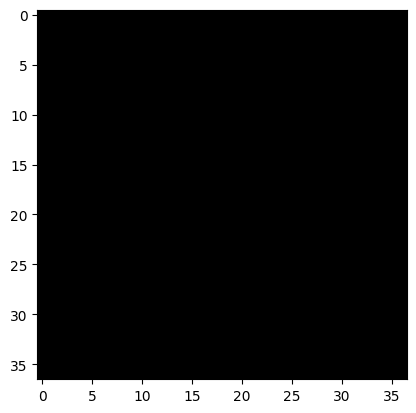

Contorno #1 -- solidity=0.68 -- area=72.50 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=106.00


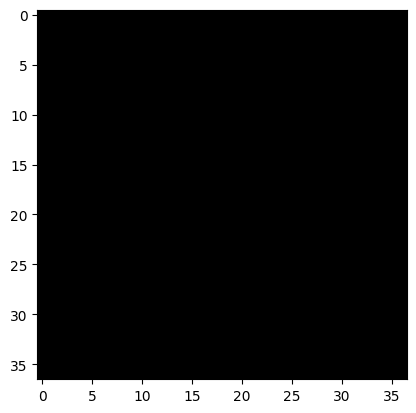

Contorno #2 -- solidity=1.00 -- area=34.00 -- aspectRatio=0.88 -- extent=0.61 -- hullArea=34.00


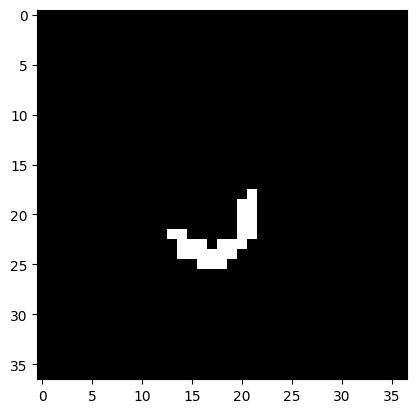

Contorno #1 -- solidity=0.88 -- area=98.50 -- aspectRatio=0.62 -- extent=0.62 -- hullArea=112.50


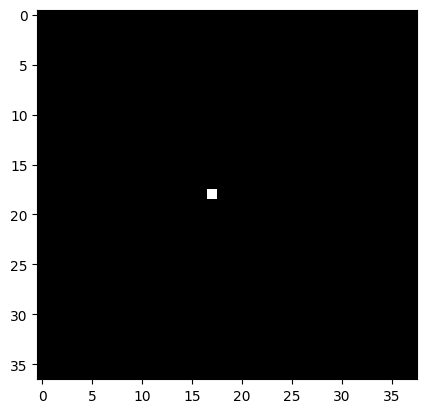

Contorno #2 -- solidity=1.00 -- area=27.00 -- aspectRatio=1.00 -- extent=0.55 -- hullArea=27.00


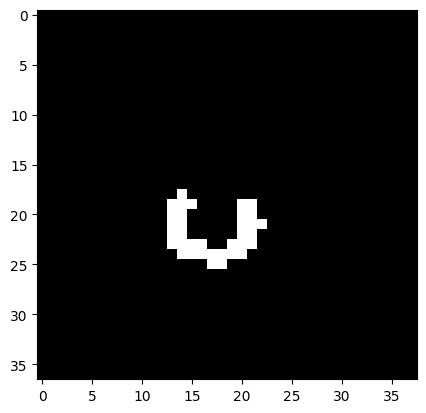

Contorno #3 -- solidity=0.98 -- area=28.50 -- aspectRatio=1.00 -- extent=0.58 -- hullArea=29.00


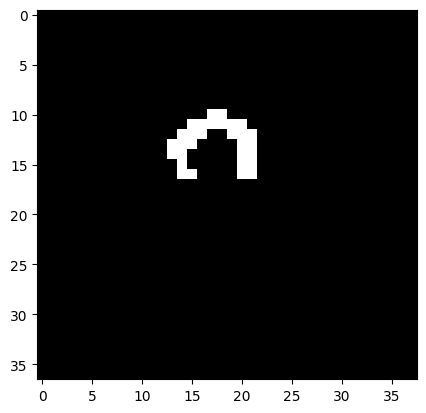

Contorno #1 -- solidity=0.35 -- area=39.50 -- aspectRatio=0.56 -- extent=0.27 -- hullArea=112.50


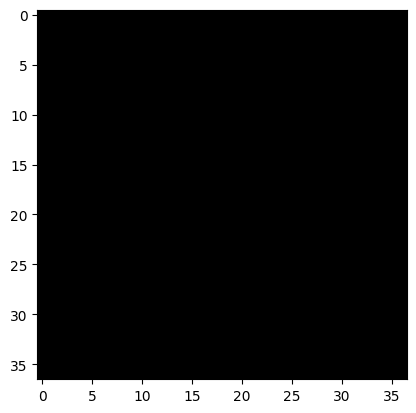

Contorno #1 -- solidity=0.30 -- area=33.00 -- aspectRatio=0.56 -- extent=0.23 -- hullArea=108.50


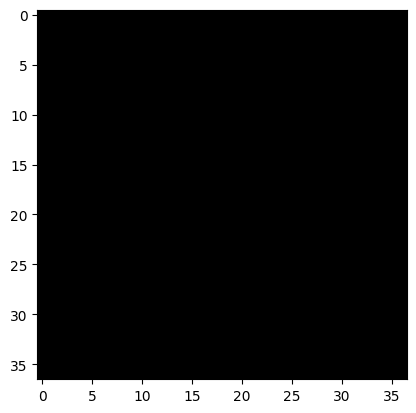

Contorno #1 -- solidity=0.69 -- area=61.00 -- aspectRatio=0.62 -- extent=0.38 -- hullArea=88.00


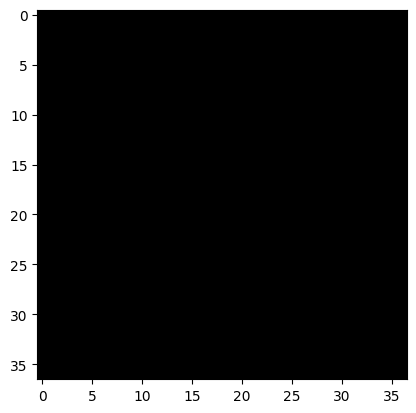

Contorno #2 -- solidity=0.94 -- area=29.00 -- aspectRatio=0.78 -- extent=0.46 -- hullArea=31.00


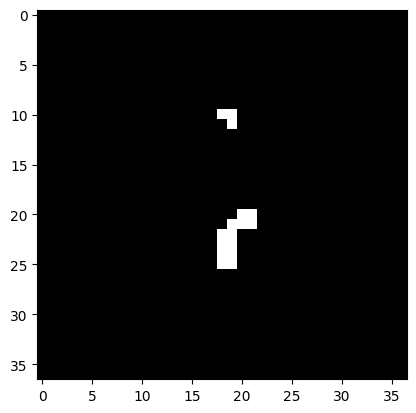

Contorno #1 -- solidity=0.30 -- area=33.00 -- aspectRatio=0.56 -- extent=0.23 -- hullArea=108.50


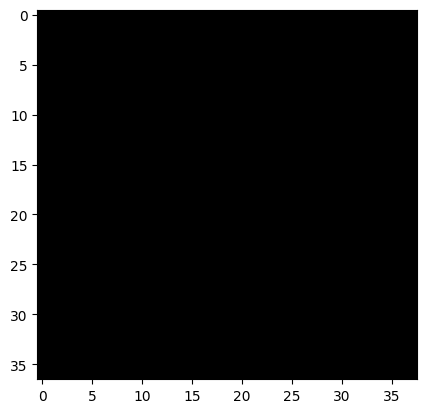

Contorno #1 -- solidity=0.70 -- area=72.00 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=103.50


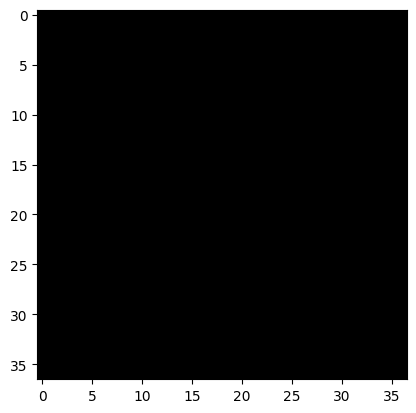

Contorno #2 -- solidity=1.00 -- area=33.00 -- aspectRatio=0.88 -- extent=0.59 -- hullArea=33.00


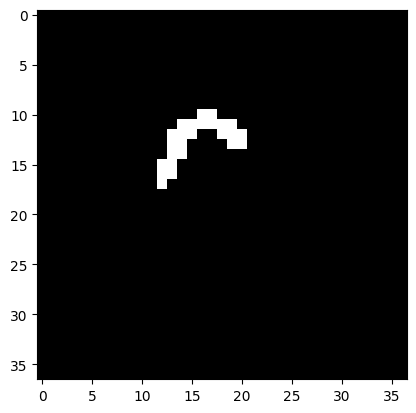

Contorno #1 -- solidity=0.33 -- area=36.50 -- aspectRatio=0.56 -- extent=0.25 -- hullArea=109.00


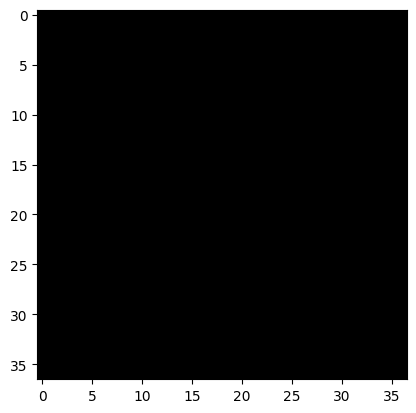

Contorno #1 -- solidity=0.29 -- area=25.00 -- aspectRatio=0.62 -- extent=0.16 -- hullArea=85.50


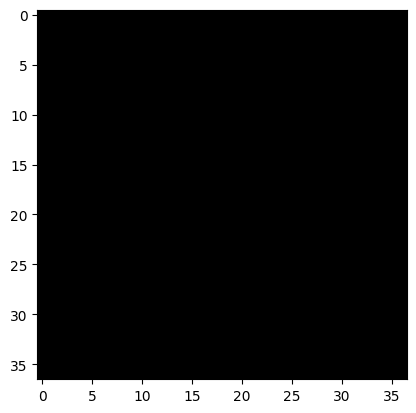

Contorno #1 -- solidity=0.68 -- area=72.50 -- aspectRatio=0.56 -- extent=0.50 -- hullArea=106.00


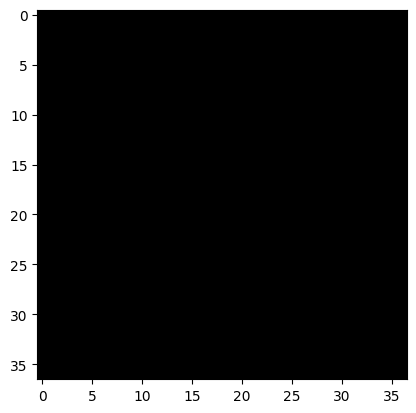

Contorno #2 -- solidity=1.00 -- area=34.00 -- aspectRatio=0.88 -- extent=0.61 -- hullArea=34.00


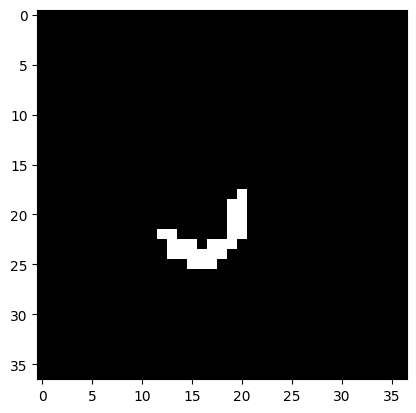

Contorno #1 -- solidity=0.35 -- area=39.50 -- aspectRatio=0.56 -- extent=0.27 -- hullArea=112.50


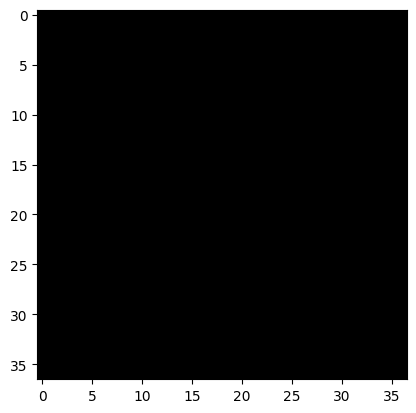

Contorno #1 -- solidity=0.69 -- area=61.00 -- aspectRatio=0.62 -- extent=0.38 -- hullArea=88.00


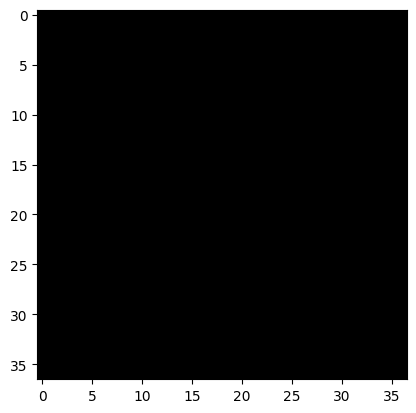

Contorno #2 -- solidity=0.94 -- area=29.00 -- aspectRatio=0.78 -- extent=0.46 -- hullArea=31.00


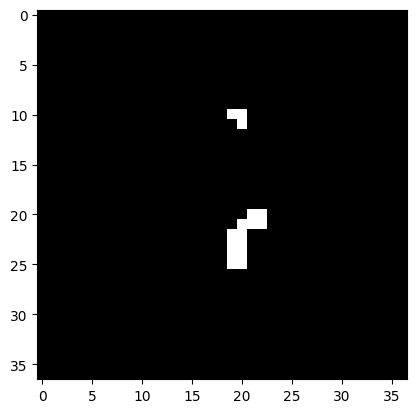

Contorno #1 -- solidity=0.29 -- area=25.00 -- aspectRatio=0.62 -- extent=0.16 -- hullArea=85.50


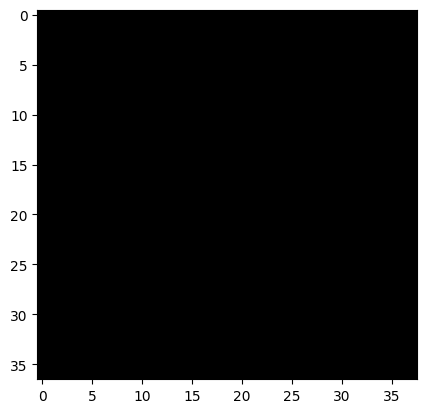

Contorno #1 -- solidity=0.29 -- area=25.00 -- aspectRatio=0.62 -- extent=0.16 -- hullArea=85.50


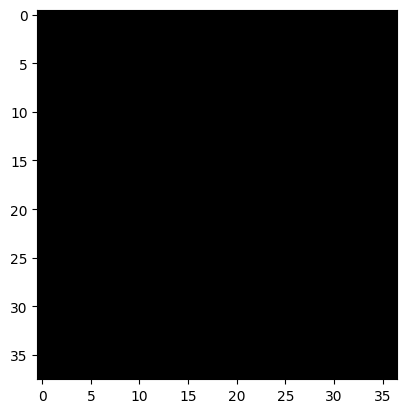

Contorno #1 -- solidity=0.69 -- area=61.00 -- aspectRatio=0.62 -- extent=0.38 -- hullArea=88.00


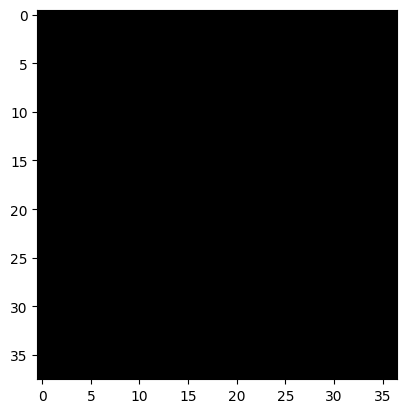

Contorno #2 -- solidity=0.94 -- area=29.00 -- aspectRatio=0.78 -- extent=0.46 -- hullArea=31.00


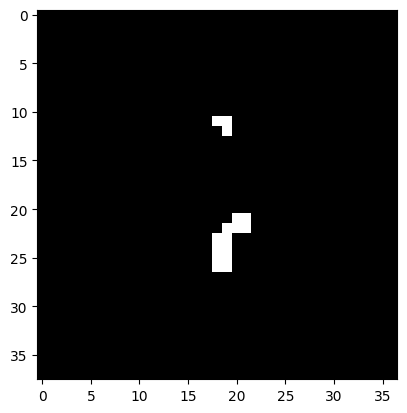

Contorno #1 -- solidity=0.30 -- area=33.00 -- aspectRatio=0.56 -- extent=0.23 -- hullArea=108.50


KeyboardInterrupt: 

In [60]:
contornoImagen(contours,thresh)

In [57]:
def funcion(contours, image):
  for (i, c) in enumerate(contours):
    # Calculamos diversas propiedades
    area = cv2.contourArea(c)
    (x, y, w, h) = cv2.boundingRect(c)
    aspectRatio = w / float(h)
    extent = area / float(w * h)
    hull = cv2.convexHull(c)
    hullArea = cv2.contourArea(hull)
    solidity = 0
    if(hullArea != 0):
      solidity = area / float(hullArea)
    if(hullArea != 0):
      # Visualizamos cada contorno y el convex hull asociado al mismo
      print("Contorno #{} -- solidity={:.2f} -- area={:.2f} -- aspectRatio={:.2f} -- extent={:.2f} -- hullArea={:.2f}".
            format(i + 1, solidity,area,aspectRatio,extent,hullArea))
      clone = image.copy()
      cv2.drawContours(clone, [c], -1, (0, 255, 0), 3)
      mostrarImagen(clone)

##Carga de Dataset

En esta parte, lo que realizaré es descargar el conjunto de imágenes

In [17]:
!wget https://github.com/IA1819/Datasets/blob/master/im%C3%A1genes.zip?raw=true -O imagenes.zip
!unzip imagenes.zip

--2024-04-23 18:09:00--  https://github.com/IA1819/Datasets/blob/master/im%C3%A1genes.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IA1819/Datasets/raw/master/im%C3%A1genes.zip [following]
--2024-04-23 18:09:00--  https://github.com/IA1819/Datasets/raw/master/im%C3%A1genes.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IA1819/Datasets/master/im%C3%A1genes.zip [following]
--2024-04-23 18:09:00--  https://raw.githubusercontent.com/IA1819/Datasets/master/im%C3%A1genes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

##Conjunto final

Ahora ya tenemos todos los pasos para leer los sudokus, generar el tablero y mostrar la solución. Definiré una función que dada la ruta de una imágen:

...

In [18]:
def resultado(path):
  sudoku_string = generaTablero(path)
  sudoku_resuelto = solve_sudoku(sudoku_string)
  display_sudoku_solution(sudoku_resuelto)

##Pruebas

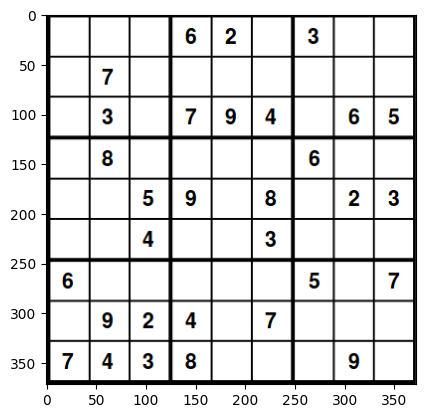

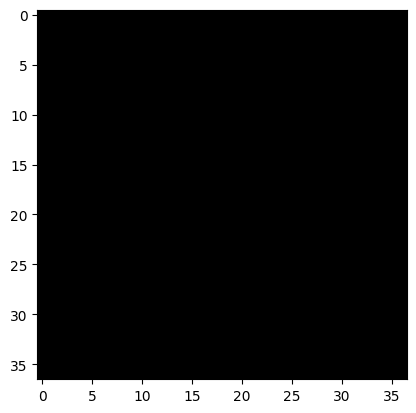

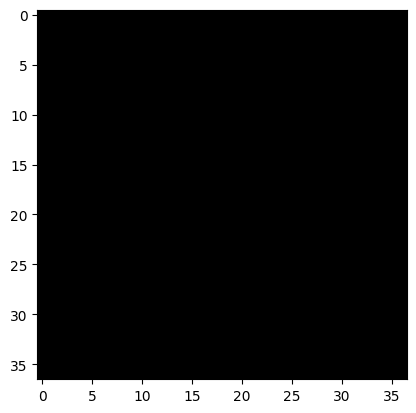

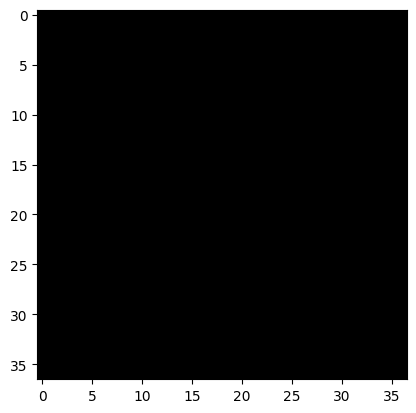

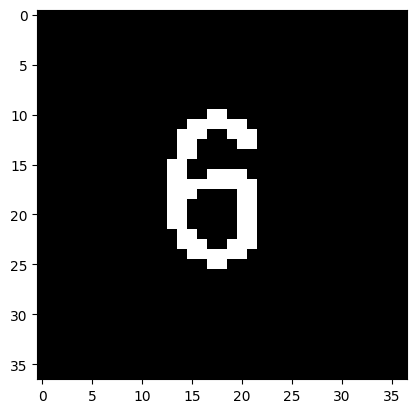

NameError: name 'resultadoCasilla' is not defined

In [40]:
resultado("imágenes/sudoku1.png")

Al finalizar el notebook recuerda guardarlo usando la opción *"Save in Github..."*.